In [ ]:
import torch
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.tensorboard import TensorBoardCallback
from fastai.callback.tracker import SaveModelCallback

from pathlib import Path
import pandas as pd
import json

In [49]:
!hostname

AORUS-X470


In [50]:
import kagglehub

# Images are from the ISPRS Potsdam dataset. Each input image in the dataset was
# divided into image patches of size 300 × 300. These patches are divided into training (~2000
# images) and testing (~400 images) datasets (see the notebooks below) and labeled with one
# or more of the following labels: {“roads”, “buildings”, “low veg”, “trees”, “cars”, “clutter”}.

# Download latest version
postdam_path = Path(kagglehub.dataset_download("deasadiqbal/private-data-1"))

print("Path to dataset files:", postdam_path)

Path to dataset files: /home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1


In [51]:
root_dir = Path('..')

datasets_dir = root_dir/'datasets'
experiments_dir = root_dir/'experiments'

In [52]:
# ssd_dataset = datasets_dir/'Semantic segmentation dataset'

# df_classes = pd.read_csv(ssd_dataset/'classes.txt', header=None)
# df_classes['name'] = df_classes[0].str.extract(r'^\d+. ([^:]+): ')[0].str.strip()
# df_classes['color'] = df_classes[0].apply(lambda x: x.split(':')[-1].strip())
# df_classes.index.name = 'class_id'
# df_classes.reset_index(inplace=True)
# df_classes.drop(columns=[0], inplace=True)


# df_classes

In [53]:
postdam_dataset = datasets_dir/'ISPRS_Potsdam'
df_classes = pd.read_csv(postdam_dataset/'classes.csv')
df_classes

,class_id,name,color
0,0,Impervious surfaces (white),"(255, 255, 255)"
1,1,Buildings (blue),"(0, 0, 255)"
2,2,Low vegetation (cyan),"(0, 255, 255)"
3,3,Trees (green),"(0, 255, 0)"
4,4,Cars (yellow),"(255, 255, 0)"
5,5,Clutter (red),"(255, 0, 0)"
6,6,Undefined (black),"(0, 0, 0)"


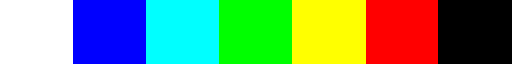

In [54]:
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

def hex2rgb(hex_color):
    if isinstance(hex_color, tuple) or isinstance(hex_color, list):
        return tuple(hex_color)
    if hex_color.startswith('#'):
        hex_color = hex_color.lstrip('#')
        t = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    else:
        t = tuple(int(x.strip()) for x in hex_color.strip('()').split(','))
    return t

ssd_cmap = ListedColormap(
    df_classes['color'].apply(lambda x: np.array(hex2rgb(x))/255.0).to_list(),
    name='skyscapes',
    N = len(df_classes)
) 

ssd_cmap

In [55]:
# image_paths = L(sorted([f for f in get_image_files(ssd_dataset) if 'masks' not in f.parts]))
image_paths = L(sorted([f for f in get_image_files(postdam_path/'patches/Images')]))
image_paths

(#2400) [Path('/home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1/patches/Images/Image_0.tif'),Path('/home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1/patches/Images/Image_1.tif'),Path('/home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1/patches/Images/Image_10.tif'),Path('/home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1/patches/Images/Image_100.tif'),Path('/home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1/patches/Images/Image_1000.tif'),Path('/home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1/patches/Images/Image_1001.tif'),Path('/home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1/patches/Images/Image_1002.tif'),Path('/home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1/patches/Images/Image_1003.tif'),Path('/home/m_zsuetam/.cache/kagglehub/datasets/deasadiq

In [56]:
class RGB2ClassMask():

    def __init__(self, df_classes, class_id_col='class_id', color_col='color'):
        self.color2id = {
            tuple(map(int, hex2rgb(row[color_col]))): row[class_id_col]
            for _, row in df_classes.iterrows()
        }
        self.id2color = {v: k for k, v in self.color2id.items()}

    def __call__(self, mask_path, verbose=False):
        mask_img = PILImage.create(mask_path)

        mask = np.array(mask_img)
        h, w, _ = mask.shape
        out = np.zeros((h, w), dtype=np.int32)
        
        for rgb, cls in self.color2id.items():
            filt = (mask == rgb).all(axis=-1)
            if verbose:
                print(f'Color {rgb} -> Class {cls}, Pixels: {filt.sum()}')
            out[filt] = cls
        
        return PILMask.create(out)
    
test = RGB2ClassMask(df_classes)

# test_mask = image_paths[0].parent.parent/'Masks'/f'{image_paths[1].stem}.png'
test_mask = image_paths[0].parent.parent/'Labels'/f"Label_{image_paths[1].stem.split('_')[1]}.tif"
print("Test mask path:", test_mask)
np.unique(test.__call__(test_mask, verbose=1), return_counts=True)

Test mask path: /home/m_zsuetam/.cache/kagglehub/datasets/deasadiqbal/private-data-1/versions/1/patches/Labels/Label_1.tif
Color (255, 255, 255) -> Class 0, Pixels: 35345
Color (0, 0, 255) -> Class 1, Pixels: 0
Color (0, 255, 255) -> Class 2, Pixels: 2329
Color (0, 255, 0) -> Class 3, Pixels: 44546
Color (255, 255, 0) -> Class 4, Pixels: 7780
Color (255, 0, 0) -> Class 5, Pixels: 0
Color (0, 0, 0) -> Class 6, Pixels: 0


(array([0, 2, 3, 4], dtype=int32), array([35345,  2329, 44546,  7780]))

In [57]:
rgb2class = RGB2ClassMask(df_classes)

mask_block = TransformBlock(
    type_tfms = lambda o: rgb2class(o),
    item_tfms=AddMaskCodes(codes=df_classes['name'].tolist()), 
    batch_tfms=IntToFloatTensor
)
# MaskBlock:
# TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), batch_tfms=IntToFloatTensor

In [58]:
def get_subset(image_paths, subset_size, subset_csv_path='postdam_dataset/train-val-split.csv', resample=False):

    if resample or not Path.exists(subset_csv_path):
        print("Creating new train-val-split.csv")

        random_image_subset = image_paths[np.random.choice(len(image_paths), size=subset_size, replace=False)]

        idx_map = {int(f.stem.split('_')[1]):i for i,f in enumerate(random_image_subset)}

        valid_idx = [idx_map[int(x.stem.split('_')[1])] for x in random_image_subset if int(x.stem.split('_')[1]) in range(2100,2400)]
        # train_idx = [i for i in range(len(random_image_subset)) if int(random_image_subset[i].stem.split('_')[1]) not in valid_idx]
        print(f"Training indices: {len(random_image_subset) - len(valid_idx)}")
        print(f"Validation indices: {len(valid_idx)} {len(valid_idx)/len(random_image_subset)*100:.2f}% (was {(2400-2100)/2400*100}% before)")

        pd.DataFrame(
            {
                'fanme': random_image_subset,
                'is_valid': [i in valid_idx for i in range(len(random_image_subset))]
            }
        ).to_csv(subset_csv_path, index=False)
    else:
        print("Using existing train-val-split.csv")
        if not Path.exists(subset_csv_path):
            df_split = pd.read_csv(subset_csv_path)
            train_idx = df_split.index[~df_split['is_valid']].tolist()
            valid_idx = df_split.index[df_split['is_valid']].tolist()
        print(f"Training indices: {len(train_idx)}")
        print(f"Validation indices: {len(valid_idx)}")

In [59]:
USE_SUBSET = False
RESAMPLE_SUBSET = False

if USE_SUBSET:
    selected_images, train_idx, valid_idx = get_subset(image_paths, subset_size=500, resample=RESAMPLE_SUBSET)
else:
    selected_images = image_paths
    train_idx, valid_idx = list(range(2100)), list(range(2100,2400))
    print(f"Training indices: {len(train_idx)}")
    print(f"Validation indices: {len(valid_idx)}")

Training indices: 2100
Validation indices: 300


In [60]:
# Semantic segmentation dataset
# mean=tensor([0.5218, 0.5283, 0.5420]),
# std=tensor([0.2436, 0.2450, 0.2526])

# Postdam dataset 
DS_MEAN = [0.3766, 0.3615, 0.3349]
DB_STD = [0.1156, 0.1142, 0.1180]

In [61]:
# IMG_SIZE = 300
IMG_SIZE = 256

db = DataBlock(
    blocks=(ImageBlock, mask_block),
    get_y = lambda o: o.parent.parent/'Labels'/f"Label_{o.stem.split('_')[1]}.tif",
    splitter=IndexSplitter(valid_idx), 
    item_tfms = Resize((IMG_SIZE), method='nearest'),
    batch_tfms=[
        *aug_transforms(size=IMG_SIZE, pad_mode='zeros', min_scale=1.0),
        Normalize.from_stats(
            # Semantic segmentation dataset
            # Postdam dataset
            mean=tensor(DS_MEAN),
            std=tensor(DB_STD)
        )
    ],
)
dls = db.dataloaders(
    selected_images, 
    bs=2
)

In [62]:
CALCULATE_STATS = False

if CALCULATE_STATS:
    n_pixels = 0
    mean = torch.zeros(3)
    var = torch.zeros(3)
    
    ds = db.datasets(source=image_paths)
    for p in ds.train.items:
        img = tensor(PILImage.create(str(p))).permute(2, 0, 1).float() / 255.0   # shape: [3, H, W]
        n = img.numel() / 3 # number of pixels per channel
        n_pixels += n

        mean += img.mean(dim=[1,2]) * n
        var  += img.var(dim=[1,2], unbiased=False) * n

    mean /= n_pixels
    std  = torch.sqrt(var / n_pixels)

    print("Mean:", mean)
    print("Std:", std)
else:
    # Semantic segmentation dataset
    # print("Mean: tensor([0.5218, 0.5283, 0.5420])")
    # print("Std: tensor([0.2436, 0.2450, 0.2526])")
    # Postdam dataset
    print("Mean: tensor([0.3766, 0.3615, 0.3349])")
    print("Std: tensor([0.1156, 0.1142, 0.1180])")


Mean: tensor([0.3766, 0.3615, 0.3349])
Std: tensor([0.1156, 0.1142, 0.1180])


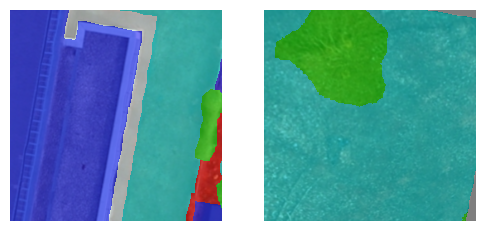

In [63]:
dls.show_batch(max_n=4, cmap=ssd_cmap)

In [71]:
# resnet50       (best cost/perf)
# efficientnet_b3
# swin_t         (amazing on aerial)
# convnext_tiny  (excellent)

# arch = resnet50
arch = resnet34

In [65]:
metrics = [
    # 1. Dice coefficient (F1 score for segmentation)
    # Best for:
    # unbalanced datasets
    # small objects (cars, houses, roads)
    # general performance measurement
    # Dice(axis=1),
    DiceMulti, 
    # 2. Intersection-over-Union (IoU / Jaccard)
    # Industry standard for segmentation competitions.
    # Per-class IoU – Small classes (cars, roads, pedestrians) 
    # get terrible IoU even when global metrics look high.
    # JaccardCoeff(axis=1), 
    JaccardCoeffMulti, 
    # 3. Recall
    # Out of all pixels that should have been a class (ground truth), 
    # how many did the model correctly identify (low False Negatives).
    # RecallMulti(),
]

In [75]:
learn = unet_learner(
    dls, 
    arch,
    pretrained=False,
    metrics = metrics,
    loss_func = CrossEntropyLossFlat(axis=1),
    # default_cbs=False # unet_learner does not support...
    cbs = [
        EarlyStoppingCallback(
            patience=10, 
            min_delta=0.0005
        ),
        TensorBoardCallback(
            log_dir=experiments_dir/'tb-log',
            log_preds=False # to surpress the error
        ),
        SaveModelCallback(
            monitor='valid_jaccard_coeff_multi', 
            fname='baseline-unet-best',
            with_opt=True,
            at_end=True # to surpress the error
        )
    ]
)
learn._grab_cbs(Recorder)[0].train_metrics = True # ... so we enable train_metrics manually

# learn.summary()

resnet50: Total params: 339,071,460

resnet34: Total params: 41,221,668

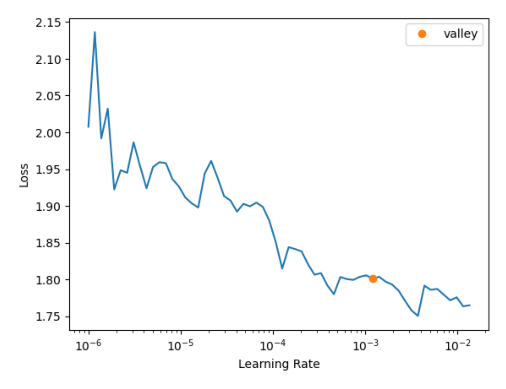

In [78]:
REFIND_LR = False
if REFIND_LR:
    learn.lr_find(start_lr=1e-6, end_lr=10)
    # plt.imsave('lr-find.png', plt.gcf().canvas.buffer_rgba())
    print("LR finder completed. Save the plot manually if needed.")
else:
    img_lr = plt.imread('../experiments/baseline-34/lr-find.png')
    plt.imshow(img_lr)
    plt.axis('off')
    plt.show()

In [79]:
lr = 1e-3

In [80]:
learn.fine_tune(
    freeze_epochs=0,
    epochs=100,
    base_lr=lr,
)

epoch,train_loss,train_dice_multi,train_jaccard_coeff_multi,valid_loss,valid_dice_multi,valid_jaccard_coeff_multi,time
0,1.068115,0.278178,0.185149,1.083840,0.401629,0.273696,01:36
1,0.994877,0.439540,0.298302,1.016119,0.418371,0.287025,01:36
2,0.987721,0.485915,0.335457,0.963548,0.492674,0.344710,01:36
3,0.915791,0.517893,0.361799,0.927054,0.508121,0.357662,01:36
4,0.970625,0.530482,0.374561,0.943962,0.516948,0.359571,01:36
5,0.926747,0.547836,0.389674,0.923026,0.502109,0.350355,01:35
6,0.931966,0.566272,0.406501,0.914452,0.546443,0.389186,01:36
7,0.880396,0.567074,0.408478,0.845439,0.574591,0.422526,01:36
8,0.889874,0.579240,0.419591,0.904313,0.541241,0.383361,01:36
9,0.824863,0.585782,0.426627,0.870695,0.549616,0.395815,01:35


Better model found at epoch 0 with valid_jaccard_coeff_multi value: 0.2736959433237443.
Better model found at epoch 1 with valid_jaccard_coeff_multi value: 0.2870245113166185.
Better model found at epoch 2 with valid_jaccard_coeff_multi value: 0.3447102962444633.
Better model found at epoch 3 with valid_jaccard_coeff_multi value: 0.35766190461825276.
Better model found at epoch 4 with valid_jaccard_coeff_multi value: 0.35957111551462634.
Better model found at epoch 6 with valid_jaccard_coeff_multi value: 0.3891862061896663.
Better model found at epoch 7 with valid_jaccard_coeff_multi value: 0.42252609945377023.
Better model found at epoch 11 with valid_jaccard_coeff_multi value: 0.4450853783821787.
Better model found at epoch 12 with valid_jaccard_coeff_multi value: 0.44926779120408544.
Better model found at epoch 16 with valid_jaccard_coeff_multi value: 0.44957264811157877.
Better model found at epoch 17 with valid_jaccard_coeff_multi value: 0.4737622043339132.
Better model found at e

In [31]:
def hist_to_df(learner):
    rec = learner.recorder
    hist = pd.DataFrame(rec.values, columns=rec.metric_names[1:-1])
    hist.index.name = 'epoch'
    return hist

In [30]:
def plot_hist(df_hist, return_df=False):
    
    split_epochs = []
    if isinstance(df_hist, list):
        split_epochs = pd.Series([len(df) for df in df_hist]).cumsum().to_list()
        df_hist = pd.concat(df_hist, ignore_index=True)
        df_hist.index.name = 'epoch'

    df_hist = pd.wide_to_long(
        df_hist.reset_index(), 
        stubnames=['train', 'valid'],
        i='epoch',
        j='metric',
        sep='_',
        suffix=r'\w+'
    ).unstack()
    # hist['valid'].head()

    def move_loss_column_first(df):
        if 'loss' in df.columns:
            cols = ['loss'] + [col for col in df.columns if col != 'loss']
            return df[cols]
        return df
    

    fig, axs = plt.subplots(1, 3, figsize=(20,5))  
    # @TODO: make this dynamic
    # axs = axs.ravel()
    # rec.plot_loss(ax=axs[0], show_epochs=False, skip_start=0)0
    # axs[0].grid()

    hist_for_plot = df_hist.stack(0, future_stack=True)
    for col, ax in zip(move_loss_column_first(hist_for_plot).columns, axs): # axs[1:]
        h = hist_for_plot[col].unstack()
        h['train'].plot(ax=ax, label='train')
        h['valid'].plot(ax=ax, label='valid')

        if split_epochs:
            for se in split_epochs[:-1]:
                ax.axvline(se, color='gray', linestyle='--', alpha=0.5)

        ax.set_title(col)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(col)
        ax.grid()
        ax.legend()

    plt.tight_layout()

    if return_df:
        return df_hist


In [83]:
full_history = []
full_history.append(hist_to_df(learn))

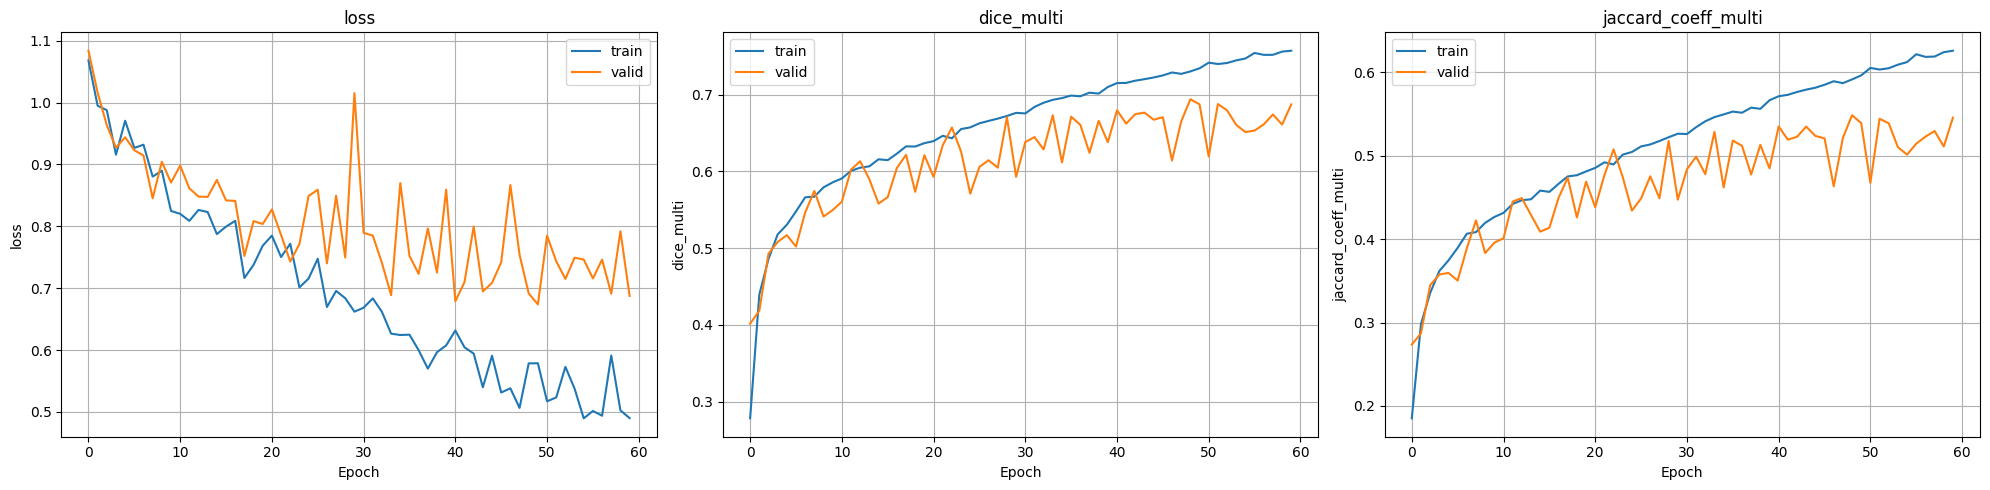

In [84]:
plot_hist(full_history)

In [ ]:
def save_full_history(history, path):
    def df_to_markdown(df):
        return df.to_markdown(index=True)

    with open(path, 'w') as f:
        for i, hist in enumerate(history):
            f.write(f"### Phase {i+1}\n")
            f.write(df_to_markdown(hist))
            f.write('\n\n')

In [ ]:
save_full_history(full_history, "full_history.md")

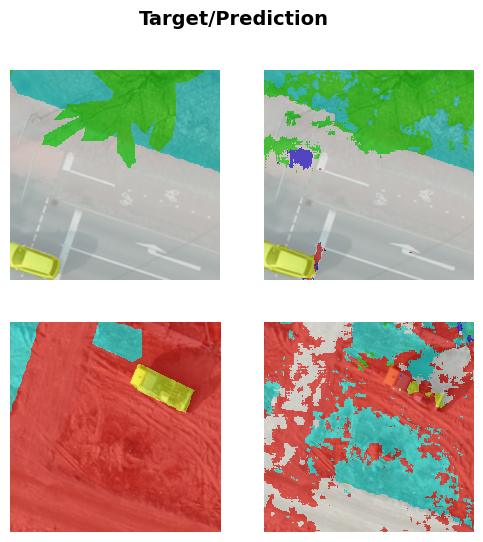

In [94]:
learn.show_results(max_n=4, cmap=ssd_cmap)

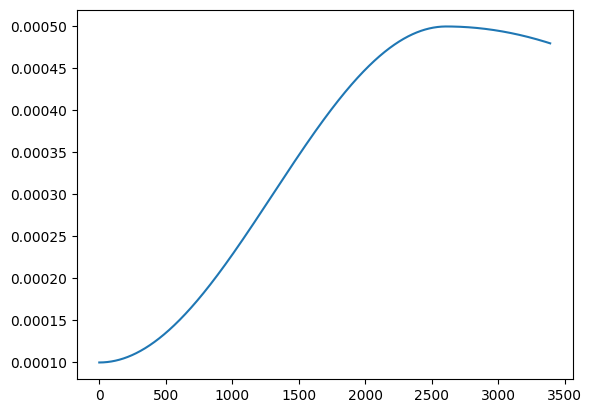

In [260]:
plt.plot(
    np.arange(len(learn.recorder.hps['lr'])),
    learn.recorder.hps['lr']
)

In [95]:
learn.export('../experiments/baseline-34/baseline-54-iou.pkl')

Reference approaches:
- [InceptionResNetV2-UNet (81% Dice Coeff. & 86% Acc)](https://www.kaggle.com/code/ayushdabra/inceptionresnetv2-unet-81-dice-coeff-86-acc)
- [Aerial Image for Semantic Segmentation (~85% Dice Coeff.)](https://www.kaggle.com/code/aletbm/aerial-image-for-semantic-segmentation#Evaluation-metrics)
- [Unet segmentation implementation with ASPP](https://www.kaggle.com/discussions/general/205141)

? Edge-Refinement Network (ERN) are extremely effective for your aerial imagery task.

# CSE-UNet

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class ConvBlock(nn.Module):
    """
    Standard Conv -> BN -> ReLU block used throughout the network.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class DoubleConv(nn.Module):
    """
    The standard U-Net encoder block: Two Conv3x3 blocks.
    """
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels),
            nn.Dropout2d(dropout_rate)
        )

    def forward(self, x):
        return self.double_conv(x)

class RFB_Skip(nn.Module):
    """
    Multi-level RFB-based skip pathways (Section 2.2).
    It consists of two parallel paths:
    1. A stack of standard 3x3 convolutions (approximating a larger kernel).
    2. A single dilated convolution.
    The outputs are concatenated.
    """
    def __init__(self, in_channels, num_stack, dilation_rate):
        super(RFB_Skip, self).__init__()
        
        # Path 1: Stack of standard convolutions (Green blocks in diagram)
        # To emulate large kernels like 7x7, we stack 3x3 convs.
        stack_layers = []
        for _ in range(num_stack):
            # 1x1 convs are used in the bottom level as per text, 3x3 elsewhere
            k = 3 if num_stack > 1 else 1 
            p = 1 if num_stack > 1 else 0
            stack_layers.append(ConvBlock(in_channels, in_channels, kernel_size=k, padding=p))
        self.stack_path = nn.Sequential(*stack_layers)

        # Path 2: Dilated Convolution (Yellow blocks in diagram)
        # Note: Section 2.2 mentions matching receptive fields.
        # For the bottom level (dilation 1), it acts as a standard conv.
        self.dilated_path = ConvBlock(in_channels, in_channels, 
                                      kernel_size=3, 
                                      padding=dilation_rate, # Padding must equal dilation to keep size
                                      dilation=dilation_rate)

    def forward(self, x):
        out_stack = self.stack_path(x)
        out_dilated = self.dilated_path(x)
        # Concatenate features from both paths
        return torch.cat([out_stack, out_dilated], dim=1)

class CSE_UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(CSE_UNet, self).__init__()
        
        filters = [64, 128, 256, 512, 1024]

        # --- ENCODER (Dual-Path) ---
        
        # Level 1
        self.enc1_main = DoubleConv(in_channels, filters[0])
        self.pool1 = nn.MaxPool2d(2)
        # Aux Path 1: Conv7x7 stride 2 (Section 2.3)
        self.enc1_aux = nn.Sequential(
            nn.Conv2d(in_channels, filters[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(filters[0])
        )

        # Level 2
        self.enc2_main = DoubleConv(filters[0], filters[1])
        self.pool2 = nn.MaxPool2d(2)
        # Aux Path 2: Conv5x5 stride 2
        self.enc2_aux = nn.Sequential(
            nn.Conv2d(filters[0], filters[1], kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(filters[1])
        )

        # Level 3
        self.enc3_main = DoubleConv(filters[1], filters[2])
        self.pool3 = nn.MaxPool2d(2)
        # Aux Path 3: Conv3x3 stride 2
        self.enc3_aux = nn.Sequential(
            nn.Conv2d(filters[1], filters[2], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters[2])
        )

        # Level 4
        self.enc4_main = DoubleConv(filters[2], filters[3])
        self.pool4 = nn.MaxPool2d(2)
        # Aux Path 4: Conv2x2 stride 2
        # Note: 2x2 kernel with stride 2 and padding 0 halves the dimension perfectly
        self.enc4_aux = nn.Sequential(
            nn.Conv2d(filters[2], filters[3], kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(filters[3])
        )

        # Bridge
        self.bridge = DoubleConv(filters[3], filters[4])

        # --- RFB SKIP PATHWAYS ---
        
        # According to Section 2.2 and Diagram
        # Top (Level 1): Stack of 3, Dilation 7
        self.rfb1 = RFB_Skip(filters[0], num_stack=3, dilation_rate=7)
        # Level 2: Stack of 2, Dilation 5
        self.rfb2 = RFB_Skip(filters[1], num_stack=2, dilation_rate=5)
        # Level 3: Stack of 1 (3x3), Dilation 3
        self.rfb3 = RFB_Skip(filters[2], num_stack=1, dilation_rate=3)
        # Level 4: Stack of 1 (1x1), Dilation 1
        # Text says: "one convolution layer with 1x1... and one dilated... dilation rate of 1"
        # We pass num_stack=1, but internal logic handles the 1x1 kernel switch for the bottom layer
        self.rfb4 = RFB_Skip(filters[3], num_stack=1, dilation_rate=1) 
        
        # Note on RFB4: The stack logic in `RFB_Skip` uses 3x3 by default. 
        # We need to manually override or create a specific block if strict adherence to "1x1" 
        # for the stack path is required. I added logic in RFB_Skip to handle this.

        # --- DECODER ---
        
        # Since RFB concatenates output, skip channels are doubled
        
        # Decoder 4
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_conv4 = nn.Conv2d(filters[4], filters[3], kernel_size=1) # Conv1x1 after upsample
        self.dec4 = DoubleConv(filters[3] + (filters[3] * 2), filters[3]) # Input = Prev + Skip(RFB x2)

        # Decoder 3
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_conv3 = nn.Conv2d(filters[3], filters[2], kernel_size=1)
        self.dec3 = DoubleConv(filters[2] + (filters[2] * 2), filters[2])

        # Decoder 2
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_conv2 = nn.Conv2d(filters[2], filters[1], kernel_size=1)
        self.dec2 = DoubleConv(filters[1] + (filters[1] * 2), filters[1])

        # Decoder 1
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_conv1 = nn.Conv2d(filters[1], filters[0], kernel_size=1)
        self.dec1 = DoubleConv(filters[0] + (filters[0] * 2), filters[0])

        # Final Output
        self.final_conv = nn.Conv2d(filters[0], num_classes, kernel_size=1)

    def forward(self, x):
        # --- ENCODER + DUAL PATH FUSION ---
        
        # Stage 1
        x1_main = self.enc1_main(x)
        x1_pool = self.pool1(x1_main)
        x1_aux = self.enc1_aux(x)
        # Fusion: Main (Pooled) + Aux
        x1_fused = x1_pool + x1_aux 
        # Apply ReLU after addition (Standard ResNet practice, though not explicitly drawn, implied by block logic)
        x1_fused = F.relu(x1_fused)

        # Stage 2
        x2_main = self.enc2_main(x1_fused)
        x2_pool = self.pool2(x2_main)
        x2_aux = self.enc2_aux(x1_fused)
        x2_fused = x2_pool + x2_aux
        x2_fused = F.relu(x2_fused)

        # Stage 3
        x3_main = self.enc3_main(x2_fused)
        x3_pool = self.pool3(x3_main)
        x3_aux = self.enc3_aux(x2_fused)
        x3_fused = x3_pool + x3_aux
        x3_fused = F.relu(x3_fused)

        # Stage 4
        x4_main = self.enc4_main(x3_fused)
        x4_pool = self.pool4(x4_main)
        x4_aux = self.enc4_aux(x3_fused)
        x4_fused = x4_pool + x4_aux
        x4_fused = F.relu(x4_fused)

        # Bridge
        x_bridge = self.bridge(x4_fused)

        # --- RFB SKIP GENERATION ---
        # The skips come from the fused encoder features before they went to the next level
        # Note: The diagram arrows for skips originate from the output of the "Main" double conv 
        # BEFORE pooling/fusion? Or from the fused result?
        # Looking at Fig 2: The arrows go Inputs -> Conv -> [Conv] -> right arrow to RFB.
        # This implies the skip comes from the STANDARD encoder path before pooling.
        
        s1 = self.rfb1(x1_main)
        s2 = self.rfb2(x2_main)
        s3 = self.rfb3(x3_main)
        s4 = self.rfb4(x4_main)

        # --- DECODER ---
        
        # Block 4
        d4 = self.up4(x_bridge)
        d4 = self.up_conv4(d4)
        # Concatenate with RFB Skip 4
        d4 = torch.cat([d4, s4], dim=1)
        d4 = self.dec4(d4)

        # Block 3
        d3 = self.up3(d4)
        d3 = self.up_conv3(d3)
        d3 = torch.cat([d3, s3], dim=1)
        d3 = self.dec3(d3)

        # Block 2
        d2 = self.up2(d3)
        d2 = self.up_conv2(d2)
        d2 = torch.cat([d2, s2], dim=1)
        d2 = self.dec2(d2)

        # Block 1
        d1 = self.up1(d2)
        d1 = self.up_conv1(d1)
        d1 = torch.cat([d1, s1], dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)

In [21]:
arch_cse = CSE_UNet(in_channels=3, num_classes=len(df_classes)).to('cuda')
arch_cse.smooth_loss = torch.tensor(0.0)

In [22]:
class CombinedLoss:
    def __init__(self, dice_weight=0.3):
        self.dice_weight = dice_weight
        self.ce_weight = 1.0 - dice_weight
        self.dice = DiceLoss(axis=1, reduction='mean')
        self.ce = CrossEntropyLossFlat(axis=1, reduction='mean')

    def __call__(self, pred, targ):
        return (
            self.dice(pred, targ) * self.dice_weight +
            self.ce(pred, targ) * self.ce_weight
        )

loss_func = CombinedLoss(dice_weight=0.4)

In [69]:
learn_cse: Learner = Learner(
    dls, 
    arch_cse,
    metrics = metrics,
    # loss_func = CrossEntropyLossFlat(axis=1),
    loss_func = CombinedLoss(dice_weight=0.4),
    # default_cbs=False # unet_learner does not support...
    cbs = [
        EarlyStoppingCallback(
            patience=10, 
            min_delta=0.0005
        ),
        TensorBoardCallback(
            log_dir=experiments_dir/'tb-log',
            log_preds=False # to surpress the error
        ),
        SaveModelCallback(
            monitor='valid_jaccard_coeff_multi', 
            fname='cse-unet-best',
            with_opt=True,
            at_end=True # to surpress the error
        )
    ]
)
learn_cse._grab_cbs(Recorder)[0].train_metrics = True # ... so we enable train_metrics manually

# learn_cse.summary()

Total params: 36,988,807

In [27]:
REFIND_LR = False
if REFIND_LR:
    learn_cse.lr_find(start_lr=1e-6, end_lr=10)

In [28]:
lr = 1e-3

In [29]:
learn_cse.fine_tune(
    freeze_epochs=0,
    epochs=100,
    base_lr=lr,
)

epoch,train_loss,train_dice_multi,train_jaccard_coeff_multi,valid_loss,valid_dice_multi,valid_jaccard_coeff_multi,time
0,1.048673,0.279322,0.185267,1.034733,0.380928,0.253818,02:29
1,1.024313,0.393363,0.266301,0.924578,0.495341,0.348455,02:29
2,0.979703,0.441189,0.303958,0.909753,0.514642,0.364453,02:28
3,0.964600,0.470138,0.326601,0.935636,0.481667,0.331095,02:28
4,0.938509,0.486926,0.341067,0.840874,0.593463,0.443014,02:29
5,0.908116,0.495058,0.349941,0.854622,0.582793,0.429051,02:29
6,0.845688,0.526628,0.376158,0.822566,0.597104,0.437964,02:29
7,0.906432,0.524955,0.375741,0.858584,0.528025,0.372442,02:29
8,0.890895,0.537954,0.385865,0.812567,0.600765,0.449156,02:29
9,0.894244,0.544497,0.392528,0.840645,0.626386,0.465519,02:29


Better model found at epoch 0 with valid_jaccard_coeff_multi value: 0.25381785997241163.
Better model found at epoch 1 with valid_jaccard_coeff_multi value: 0.3484552890238326.
Better model found at epoch 2 with valid_jaccard_coeff_multi value: 0.3644528750927354.
Better model found at epoch 4 with valid_jaccard_coeff_multi value: 0.44301435126482347.
Better model found at epoch 8 with valid_jaccard_coeff_multi value: 0.44915626514842094.
Better model found at epoch 9 with valid_jaccard_coeff_multi value: 0.4655192512664547.
Better model found at epoch 13 with valid_jaccard_coeff_multi value: 0.47984364081117753.
Better model found at epoch 14 with valid_jaccard_coeff_multi value: 0.4805803388214345.
Better model found at epoch 20 with valid_jaccard_coeff_multi value: 0.5034582711437514.
Better model found at epoch 27 with valid_jaccard_coeff_multi value: 0.5464438176999654.
Better model found at epoch 35 with valid_jaccard_coeff_multi value: 0.5536499275147136.
Better model found at e

In [32]:
full_history = []
full_history.append(hist_to_df(learn_cse))

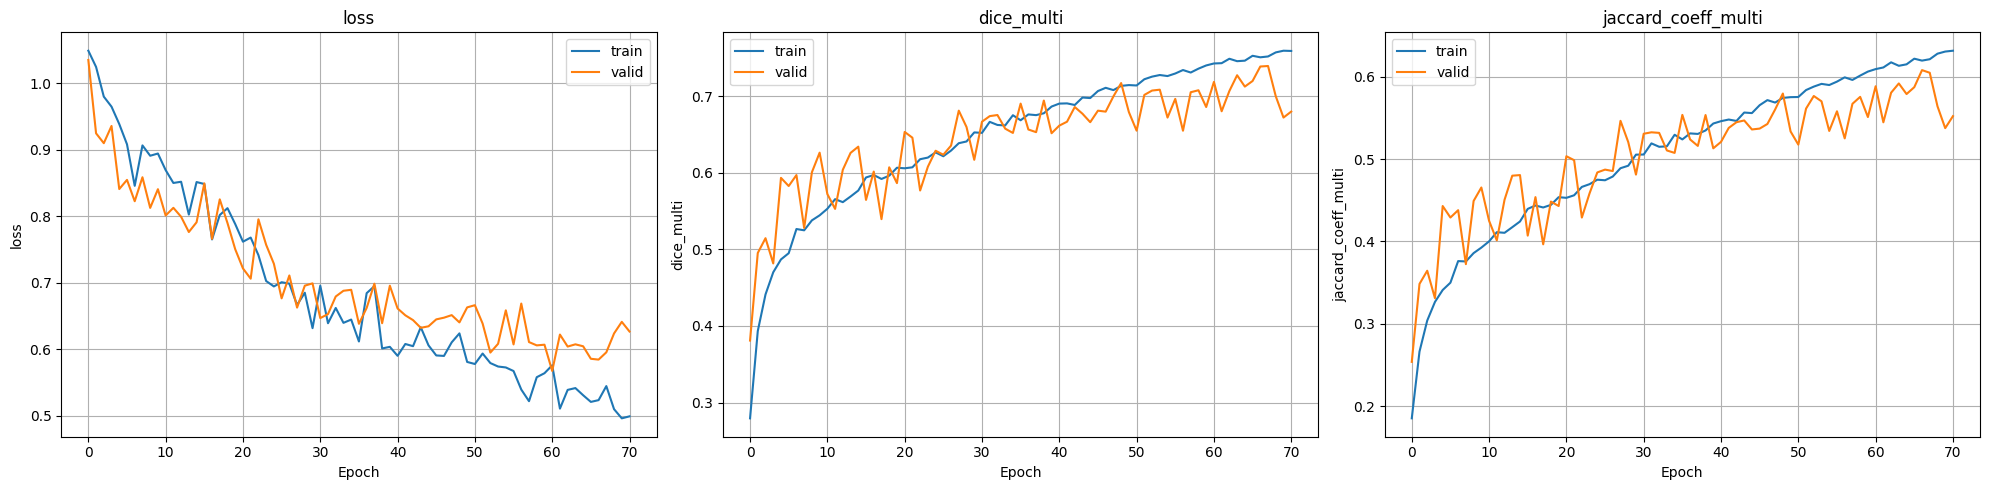

In [33]:
plot_hist(full_history)

**Second Phase**

If the training stops before Epoch 100, we resume the training with a much lower LR to try and eliminate the bounce.

In [34]:
learn_cse.load('cse-unet-best')

In [35]:
learn_cse.unfreeze() # just to be sure
learn_cse.fit_one_cycle(
    20,
    1e-4
)

epoch,train_loss,train_dice_multi,train_jaccard_coeff_multi,valid_loss,valid_dice_multi,valid_jaccard_coeff_multi,time
0,0.480652,0.773255,0.647942,0.572884,0.710579,0.582992,02:29
1,0.474380,0.776518,0.652065,0.591813,0.699227,0.566458,02:29
2,0.489027,0.775385,0.650288,0.577381,0.707072,0.578893,02:29
3,0.485362,0.776833,0.651572,0.600754,0.690864,0.562625,02:29
4,0.500333,0.771826,0.646513,0.575453,0.726574,0.594163,02:29
5,0.512179,0.774562,0.649937,0.571314,0.717852,0.590094,02:29
6,0.474419,0.775436,0.650175,0.559737,0.735621,0.606060,02:29
7,0.490022,0.776493,0.652088,0.595564,0.688385,0.564546,02:29
8,0.498484,0.778140,0.653800,0.573005,0.713225,0.588468,02:29
9,0.491281,0.779027,0.655370,0.589958,0.717770,0.588057,02:29


Better model found at epoch 0 with valid_jaccard_coeff_multi value: 0.5829922371263142.
Better model found at epoch 4 with valid_jaccard_coeff_multi value: 0.5941627962177743.
Better model found at epoch 6 with valid_jaccard_coeff_multi value: 0.6060601202035155.
Better model found at epoch 11 with valid_jaccard_coeff_multi value: 0.6201197259019058.


In [36]:
full_history.append(hist_to_df(learn_cse))

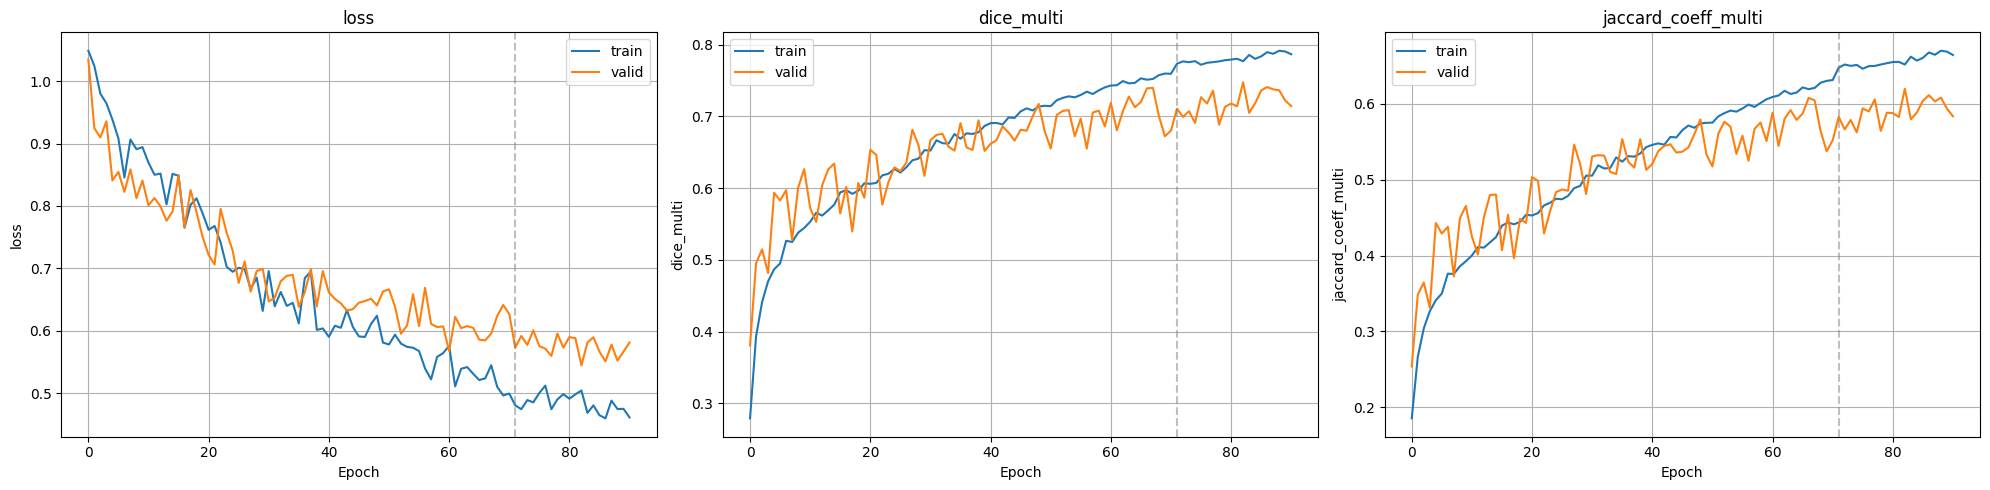

In [37]:
plot_hist(full_history)

In [ ]:
save_full_history(full_history, "full_history.md")

TypeError: Invalid shape (7, 256, 256) for image data

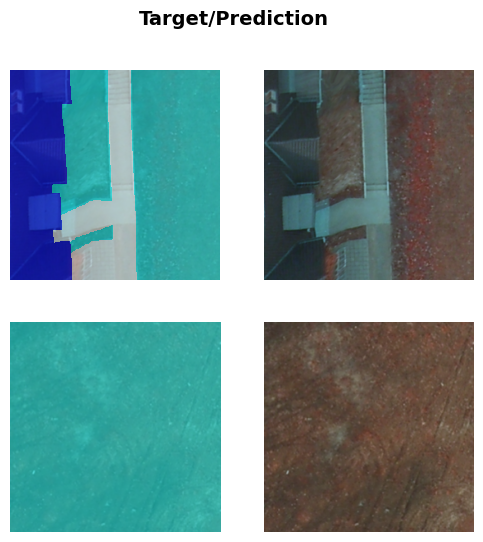

In [46]:
learn_cse.show_results(max_n=4, cmap=ssd_cmap)

In [47]:
learn_cse.export('../experiments/cse-updated/cse-62-iou.pkl')

**Notes**:
- the cse-unet needed 256x256 input size to work properly
- cse-unet is 10x smaller